### DEMDP01 
# Timber Harvesting Model - Cubic Spline Approximation

Profit maximizing owner of a commercial tree stand must decide when to clearcut the stand.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from compecon import DPmodel, BasisSpline, demo, NLP

### Model Parameters
Assuming that the unit price of biomass is $p=1$, the cost to clearcut-replant is $\kappa=0.2$, the stand carrying capacity $s_{\max}=0.5$, biomass growth factor is $\gamma=10\%$ per period, and the annual discount factor $\delta=0.9$.

In [2]:
price = 1.0
kappa = 0.2
smax  = 0.5
gamma = 0.1
delta = 0.9

### State Space
The state variable is the stand biomass, $s\in [0,s_{\max}]$.  

Here, we represent it with a cubic spline basis, with $n=200$ nodes.


In [3]:
n = 200
basis = BasisSpline(n, 0, smax, labels=['biomass'])

### Action Space
The action variable is $j\in\{0:\text{'keep'},\quad 1:\text{'clear cut'}\}$.


In [4]:
options = ['keep', 'clear-cut']

### Reward function
If the farmer clears the stand, the profit is the value of selling the biomass $ps$ minus the cost of clearing and replanting $\kappa$, otherwise the profit is zero.

In [5]:
def reward(s, x, i , j):
    return (price * s - kappa) * j

### State Transition Function
If the farmer clears the stand, it begins next period with $\gamma s_{\max}$ units. If he keeps the stand, then it grows to $s + \gamma (s_{\max} - s)$.


In [6]:
def transition(s, x, i, j, in_, e):
    if j:
        return np.full_like(s, gamma * smax)
    else:
        return s + gamma * (smax - s)

### Model Structure
The value of the stand, given that it contains $s$ units of biomass at the beginning of the period, satisfies the Bellman equation

\begin{equation} V(s) = \max\left\{(ps-\kappa) + \delta V(\gamma s_{\max}),\quad \delta V[s+\gamma(s_{\max}-s)]  \right\}   \end{equation}

To solve and simulate this model, use the CompEcon class ```DPmodel```.

In [26]:
model = DPmodel(basis, reward, transition,
                discount=delta,
                j=options)

S = model.solve()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       3.1e-01    0.0000
   1       1.1e-01    0.0186
   2       1.1e-02    0.0221
   3       4.6e-03    0.0221
   4       1.9e-16    0.0378
Elapsed Time =    0.04 Seconds


The ```solve``` method retuns a pandas ```DataFrame```, which can easily be used to make plots. To see the first 10 entries of `S`, we use the `head` method

In [27]:
S.head()

,biomass,value,resid,j*,value[keep],value[clear-cut]
biomass,,,,,,
0.000000,0.000000,0.067287,1.387779e-17,keep,0.067287,-0.132713
0.000250,0.000250,0.067320,-7.491474e-09,keep,0.067320,-0.132462
0.000500,0.000500,0.067353,-5.953236e-09,keep,0.067353,-0.132212
0.000750,0.000750,0.067387,-1.332984e-09,keep,0.067387,-0.131962
0.001001,0.001001,0.067420,7.309628e-10,keep,0.067420,-0.131712


## Analysis

To find the biomass level at which it is indifferent to keep or to clear cut, we interpolate as follows:

In [23]:
scrit = NLP(lambda s: model.Value_j(s).dot([1,-1])).broyden(0.0)[0]
vcrit = model.Value(scrit)
print(f'When the biomass is {scrit:.5f} its value is {vcrit:.5f} regardless of the action taken by the manager')

When the biomass is 0.30669 its value is 0.17402 regardless of the action taken by the manager


### Plot the Value Function and Optimal Action

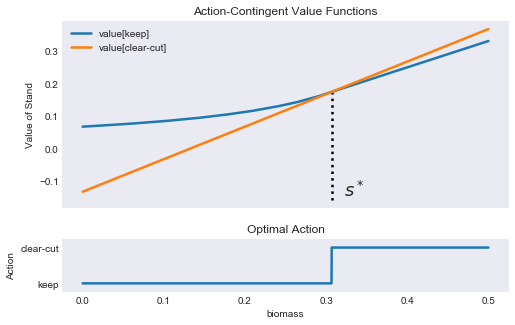

In [37]:
fig1 = plt.figure(figsize=[8,5])
gs = gridspec.GridSpec(2, 1,height_ratios=[3.5, 1])

S[['value[keep]', 'value[clear-cut]']].plot(ax= plt.subplot(gs[0]))
plt.title('Action-Contingent Value Functions')
plt.xlabel('')
plt.ylabel('Value of Stand')
plt.xticks([])


ymin,ymax = plt.ylim()
plt.vlines(scrit,ymin, vcrit,linestyle=':')
demo.annotate(scrit, ymin,'$s^*$',ms=0)

S['j*'].cat.codes.plot(ax=plt.subplot(gs[1]))
plt.title('Optimal Action')
plt.ylabel('Action')
plt.ylim([-0.25,1.25])
plt.yticks([0,1],options)
plt.legend([])

### Plot Residuals

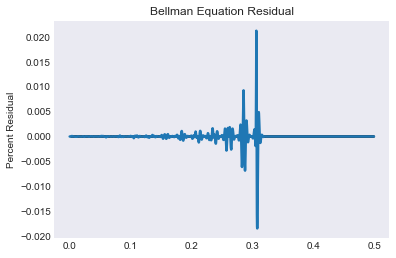

In [34]:
S['resid2'] = 100*S.resid / S.value

fig2 = demo.figure('Bellman Equation Residual','','Percent Residual')
plt.plot(S['resid2'])
plt.hlines(0,0,smax,'k')

###  Simulation

The path followed by the biomass is computed by the ```simulate()``` method. Here we simulate 32 periods starting with a biomass level $s_0 = 0$.

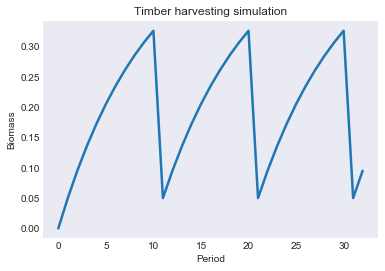

In [33]:
H = model.simulate(32, 0.0)

fig3 = demo.figure('Timber harvesting simulation','Period','Biomass')
plt.plot(H['biomass'])


In [ ]:
#demo.savefig([fig1, fig2, fig3])